In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import Geohash

## Import dataset

In [2]:
df = pd.read_csv("dataset/Traffic Management/training.csv")

df['coordinate'] = df['geohash6'].apply(Geohash.decode)
df['latitude'] = df['coordinate'].apply(lambda x: x[0])
df['longitude'] = df['coordinate'].apply(lambda x: x[1])

df['hour_of_day'] = np.int32(df['timestamp'].apply(lambda x: x.split(':')[0]))
df['minute_quarter'] = np.int32(df['timestamp'].apply(lambda x: x.split(':')[1]))

df['week_no'] = np.int32(np.floor(df['day'] / 7) + 1)
# we don't know whether dow starts in which day
df['day_of_week'] = df['day'] % 7

# datetime-like field
df['dt_hour'] = df.apply(lambda x: ('{} {:02d}:00'.format(str(x['day']), x['hour_of_day'])), axis=1)
df['dt'] = df.apply(lambda x: ('{} {:02d}:{:02d}'.format(str(x['day']), x['hour_of_day'], x['minute_quarter'])), axis=1)

## Exploration

In [40]:
print("Number of locations: {:,.0f}".format(df['geohash6'].nunique()))

Number of locations: 1,329


We observe weekly seasonality on the dataset. Meanwhile, demand is higher during 0 to 12; less demand is observed during evening. While we hypothesize that the time use UTC, we don't convert it since it will change the day sequence.

/home/elvyna/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



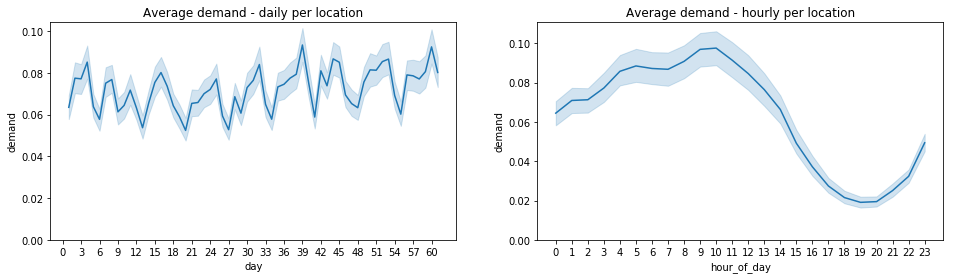

In [44]:
f, ax = plt.subplots(figsize=(16,4), ncols=2)

d = df.groupby(['day','geohash6']).agg({'demand':np.median}).reset_index()

sns.lineplot(
    x=d['day'],
    y=d['demand'],
    ax=ax[0]
);

ax[0].set_title("Average demand - daily per location")
ax[0].set_xticks(np.arange(0,63,3))
ax[0].set_ylim(0,)

d = df.groupby(['hour_of_day','geohash6']).agg({'demand':np.median}).reset_index()

sns.lineplot(
    x=d['hour_of_day'],
    y=d['demand']
);

ax[1].set_title("Average demand - hourly per location")
ax[1].set_xticks(np.arange(0,24,1))
ax[1].set_ylim(0,)

plt.show();

Each location has different demand pattern. Also, there are locations with missing values (no demand at some days).

/home/elvyna/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



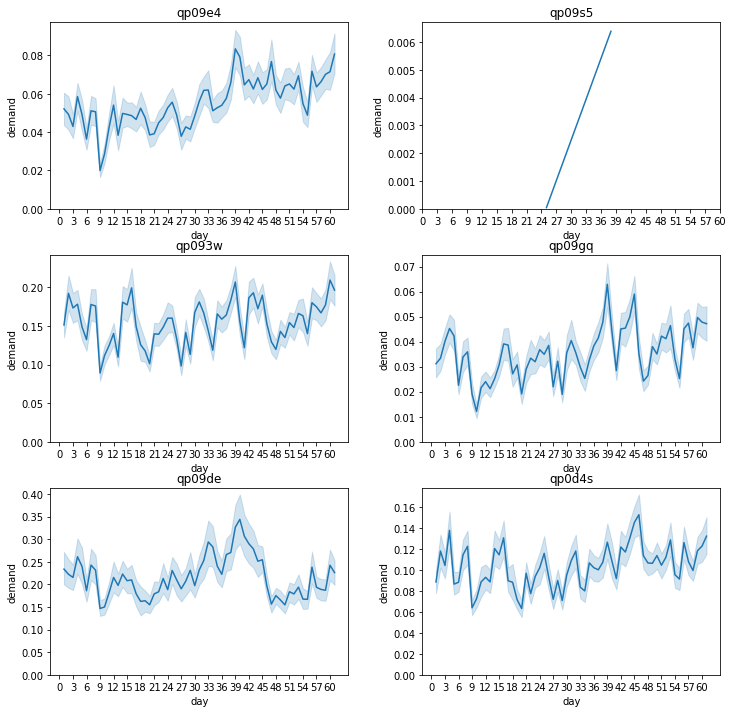

In [46]:
f, ax = plt.subplots(figsize=(12,12), ncols=2, nrows=3)
plt.subplots_adjust(wspace=.25, hspace=.25)
i = 0
j = 0

for geo in np.random.choice(np.arange(df['geohash6'].nunique()), 6):
    sns.lineplot(
        data=df.loc[(df['geohash6'] == df['geohash6'].unique()[geo])],
        x='day',
        y='demand',
        ax=ax[i][j]
    )
    
    ax[i][j].set_title(df['geohash6'].unique()[geo])
    ax[i][j].set_ylim(0,)
    ax[i][j].set_xticks(np.arange(0,63,3))
    
    if j == 1:
        i += 1
        j = 0
    else:
        j += 1
    
    
plt.show();

## Baseline Model - using daily data

### 1. Use average demand 

Before we conduct further research, we try to forecast using simpler method.

In [47]:
base = train.groupby(['dt']).agg({'demand':np.median}).reset_index()

# append with test data & median of train data
arr = np.zeros((test['dt'].nunique()))
arr += np.median(base['demand'])

base = pd.concat(
        [base,
        pd.DataFrame(
            data = [sorted(test['dt'].unique()), arr.tolist()]
        ).T.rename(columns={0:'dt',1:'demand'})]
    )

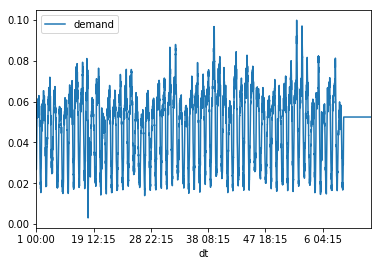

In [48]:
base.plot(
    kind='line',
    x='dt',
    y='demand'
)

plt.show();

In [49]:
base_test = test.merge(
    base.rename(columns={'demand':'yhat'}),
    how='left',
    on='dt'
)

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("RMSE\t: {:,.5f}".format(np.sqrt(mean_squared_error(base_test['demand'],base_test['yhat']))))
print("MAE\t: {:,.5f}".format((mean_absolute_error(base_test['demand'],base_test['yhat']))))

RMSE	: 0.17953
MAE	: 0.09142


### 2. Exponential smoothing

In [51]:
base = train.groupby(['dt']).agg({'demand':np.median}).reset_index()

In [52]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(base['demand'])

# fit model
model_fit = model.fit(smoothing_level=0.5)

# make prediction
yhat = model_fit.predict(start=1, end=test['dt'].nunique())

In [53]:
# append with test data & median of train data
arr = np.zeros((test['dt'].nunique()))
arr += np.array(yhat)

base = pd.concat(
        [base,
        pd.DataFrame(
            data = [sorted(test['dt'].unique()), arr.tolist()]
        ).T.rename(columns={0:'dt',1:'demand'})]
    )

base_test = test.merge(
    base.rename(columns={'demand':'yhat'}),
    how='left',
    on='dt'
)

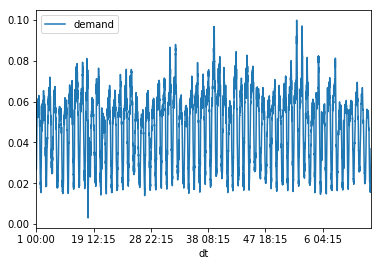

In [54]:
base.plot(
    kind='line',
    x='dt',
    y='demand'
)

plt.show();

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("RMSE\t: {:,.5f}".format(np.sqrt(mean_squared_error(base_test['demand'],base_test['yhat']))))
print("MAE\t: {:,.5f}".format((mean_absolute_error(base_test['demand'],base_test['yhat']))))

RMSE	: 0.17945
MAE	: 0.09038


Using the baseline approach, the RMSE is roughly 0.179. Let's see if we can do better by using more advanced techniques.

## Split into training and test set

We use last 5 days data for test set. There are some locations which are not in the training set.

In [3]:
test_days = 5
print('Read data with size: ', df.shape)
original_columns = df.columns.tolist()
df['test_mask'] = df['day'] > np.max(df['day']) - test_days
train = df.loc[~df['test_mask']]
print('Train size: ', train.shape)
test = df.loc[df['test_mask'], ['geohash6', 'day','timestamp', 'demand','dt','hour_of_day','minute_quarter']]
print('Validation size: ', test.shape)

train_x = train.loc[:, train.columns != 'demand']
train_y = train.loc[:, 'demand']

Read data with size:  (4206321, 13)
Train size:  (3845621, 14)
Validation size:  (360700, 7)


In [4]:
print("Location in training set: {:,.0f}; location in test set: {:,.0f}.".format(
    train['geohash6'].nunique(),
    test['geohash6'].nunique()
))

Location in training set: 1,328; location in test set: 1,290.


In [5]:
train_mean = train.groupby('geohash6').agg({'demand': np.mean}).reset_index().rename(columns={'demand':'demand_mean'})

train = train.merge(
    train_mean,
    how='left',
    on='geohash6'
)

# normalize demand with its average, to observe the trend
train['demand_norm'] = train['demand'] / train['demand_mean']

## Feature engineering

Based on each location's summary statistics, we attempt to cluster them.

We summarize demand of each location based on hour of day, day, day of week, week number, and minute quarter. Instead of using its real demand (which is already normalized to [0,1]), we normalize each location's real demand based on its average demand.

$\text{demand norm}_i = \frac{\text{demand}_i}{\text{average demand}_i}$

Using this normalized demand, we aim to forecast **trend** of each location's demand (not the real value).

In [6]:
train_pivot = pd.DataFrame({
    'geohash6': train['geohash6'].unique()
})

for col in ['hour_of_day','day','minute_quarter','day_of_week','week_no']:
    d = train.groupby(['geohash6',
                      col,
                      ]).agg({'demand_norm':np.median}).reset_index()

    d_pivot = d.pivot_table(
                index='geohash6',
                columns=col,
                values='demand_norm'
            ).reset_index()

    for col_rename in d_pivot.columns[~(d_pivot.columns.isin(['geohash6']))]:
        d_pivot.rename(columns={col_rename: '{}_{}'.format(col, col_rename)},
                       inplace=True)
        
    train_pivot = train_pivot.merge(
        d_pivot,
        how='left',
        left_on='geohash6',
        right_on='geohash6'
    )

In [7]:
train_pivot = train_pivot.merge(
    train[['geohash6','demand_mean']].drop_duplicates(),
    how='left',
    on='geohash6'
)

Prior to clustering, we reduce dimensions of the training data using UMAP.

In [8]:
import umap
import hdbscan

RND = 101
red_umap =  umap.UMAP(random_state=RND)
X = red_umap.fit_transform(train_pivot[(train_pivot.columns[~(train_pivot.columns.isin(['geohash6','demand_norm']))])].fillna(0))

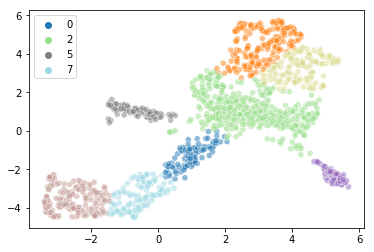

In [9]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(random_state=RND, n_components=8)
gmm.fit(X)

sns.scatterplot(
    x = X[:,0],
    y = X[:,1],
    hue = gmm.predict(X),
    alpha = 0.5,
    palette = 'tab20'
);

In [10]:
train_pivot['group'] = gmm.predict(X)

## Model training

Time series approach, using Prophet library. Since Prophet requires datetime-like field as input, we assume that the date equals to January 1, 2019 plus `day` and `hour of day`. Later on, we convert the datetime field back to its previous form.

In [11]:
train_agg_day = train.groupby(['day','hour_of_day']).agg({'demand': np.median}).reset_index()
test_agg_day = test.groupby(['day','hour_of_day']).agg({'demand':np.median}).reset_index().rename(columns={'demand':'y'})

In [12]:
train_agg_day['ds'] = train_agg_day['day'].apply(lambda x: (pd.to_datetime('2019-01-01') + np.timedelta64(x,'D')))
train_agg_day['ds'] = train_agg_day.apply(lambda x: (x['ds'] + np.timedelta64(x['hour_of_day'],'h')), axis=1)
train_agg_day = train_agg_day[['ds','demand']].copy()
train_agg_day.rename(columns={'demand':'y'}, inplace=True)

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_prediction(y_pred, y_true):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = (mean_absolute_error(y_true, y_pred))
    print("RMSE\t: {:,.5f}".format(rmse))
    print("MAE\t: {:,.5f}".format(mae))

We could adjust several parameters based on our assumptions, one of them is fourier order. While error decreases if we use higher order, but the model is prone to overfitting. Thus, we only pick order = 2.


 Fourier order: 1
In sample evaluation:
RMSE	: 0.00583
MAE	: 0.00420
Out of sample evaluation:
RMSE	: 0.00608
MAE	: 0.00527

 Fourier order: 2
In sample evaluation:
RMSE	: 0.00583
MAE	: 0.00419
Out of sample evaluation:
RMSE	: 0.00598
MAE	: 0.00513

 Fourier order: 3
In sample evaluation:
RMSE	: 0.00580
MAE	: 0.00418
Out of sample evaluation:
RMSE	: 0.00602
MAE	: 0.00505

 Fourier order: 4
In sample evaluation:
RMSE	: 0.00580
MAE	: 0.00418
Out of sample evaluation:
RMSE	: 0.00590
MAE	: 0.00495

 Fourier order: 5
In sample evaluation:
RMSE	: 0.00579
MAE	: 0.00417
Out of sample evaluation:
RMSE	: 0.00591
MAE	: 0.00490


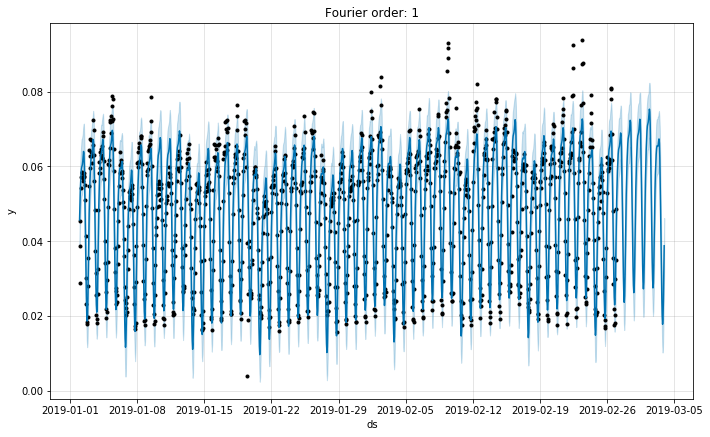

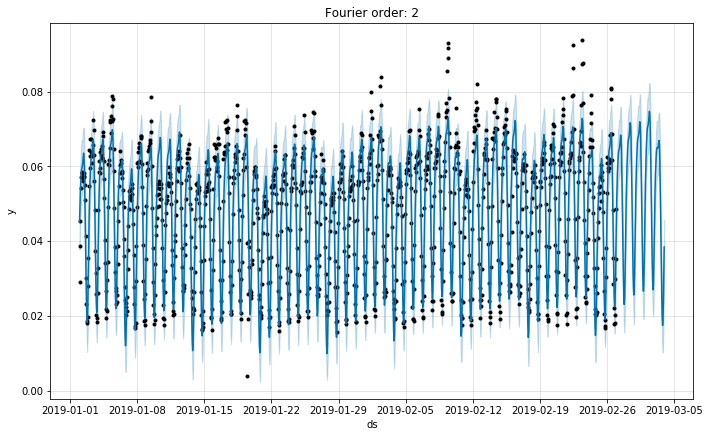

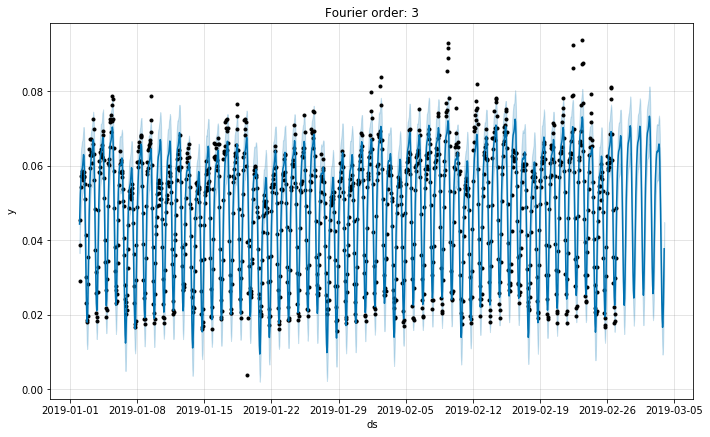

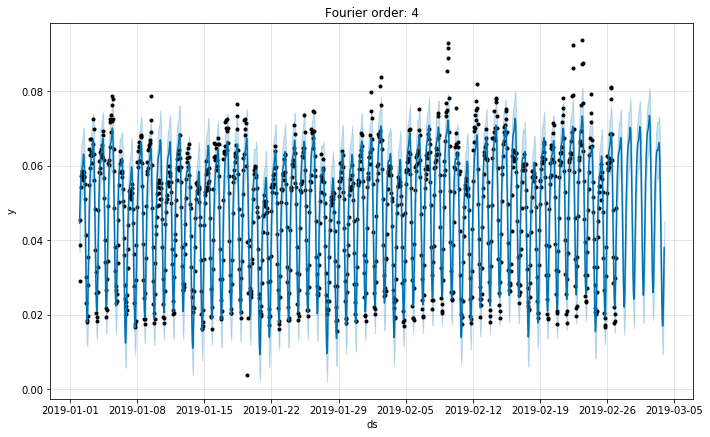

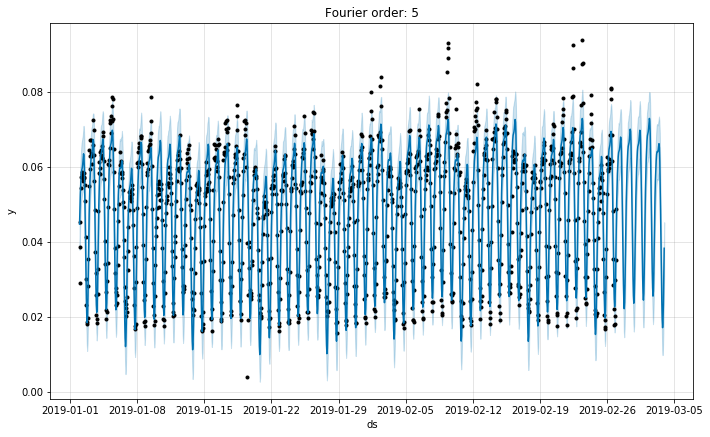

In [14]:
# observe best fourier_order parameter value
from fbprophet import Prophet

forecast_agg_all = {}

for order in range(5):
    m = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True);
    m.add_seasonality(period=30.4375, fourier_order=order+1, name='monthly');
    m.fit(train_agg_day);
    future = m.make_future_dataframe(periods=120, freq='H');
    forecast_agg_all[order+1] = m.predict(future);
    m.plot(forecast_agg_all[order+1]);
    plt.title("Fourier order: {}".format(order+1));
    
    print("\n Fourier order: {}".format(order+1))
    print("In sample evaluation:")
    evaluate_prediction(forecast_agg_all[order+1].loc[:train_agg_day.shape[0]-1,'yhat'], train_agg_day['y'])
    print("Out of sample evaluation:")
    evaluate_prediction(forecast_agg_all[order+1].loc[train_agg_day.shape[0]:,'yhat'], test_agg_day['y'])
    
plt.show();

### Overall - hourly

On this attempt, we create one model to forecast real demand of all locations.

In sample evaluation:
RMSE	: 0.00580
MAE	: 0.00418
Out of sample evaluation:
RMSE	: 0.00602
MAE	: 0.00505


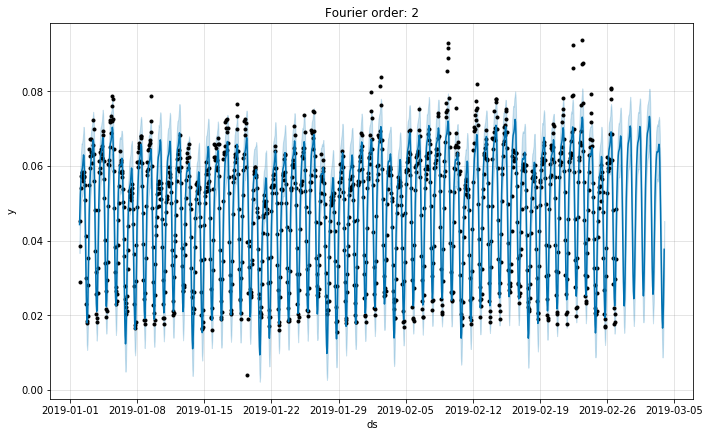

In [15]:
from fbprophet import Prophet

order = 2
m = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True);
m.add_seasonality(period=30.4375, fourier_order=order+1, name='monthly');
m.fit(train_agg_day);
future = m.make_future_dataframe(periods=120, freq='H');
forecast_agg_all = m.predict(future);
m.plot(forecast_agg_all);
plt.title("Fourier order: {}".format(order));

print("In sample evaluation:")
evaluate_prediction(forecast_agg_all.loc[:train_agg_day.shape[0]-1,'yhat'], train_agg_day['y'])
print("Out of sample evaluation:")
evaluate_prediction(forecast_agg_all.loc[train_agg_day.shape[0]:,'yhat'], test_agg_day['y'])

plt.show();

In [16]:
day_past = {
    1: 0,
    2: 31,
    3: 28+31
}

forecast_agg_all['day'] = forecast_agg_all.apply(lambda x: x['ds'].date().day - 1 + day_past[x['ds'].date().month], axis=1)
forecast_agg_all['hour_of_day'] = forecast_agg_all['ds'].dt.hour

train = train.merge(
    forecast_agg_all[['day','hour_of_day','yhat']],
    how='left',
    on=['day','hour_of_day']
).rename(columns={'yhat':'yhat_prophet_overall'})

test = test.merge(
    forecast_agg_all[['day','hour_of_day','yhat']],
    how='left',
    on=['day','hour_of_day']
).rename(columns={'yhat':'yhat_prophet_overall'})

In [17]:
evaluate_prediction(train['yhat_prophet_overall'], train['demand'])

RMSE	: 0.16484
MAE	: 0.08218


In [18]:
evaluate_prediction(test['yhat_prophet_overall'], test['demand'])

RMSE	: 0.17653
MAE	: 0.08978


### Per cluster - hourly

Let's see whether we could get better results by building several models based on the clustered locations.

In [19]:
train = train.merge(
    train_pivot[['geohash6','group']],
    how='left',
    on='geohash6'
)

test = test.merge(
    train_pivot[['geohash6','group','demand_mean']],
    how='left',
    on='geohash6'
)

# set default group to 0
test.loc[~(
    test['group'].isin(train['group'].unique())
), 'group'] = 0

test['group'] = np.int64(test['group'])

# set default demand_mean of new locations
test.loc[(test['demand_mean'].isnull()), 'demand_mean'] = np.mean(test.loc[(test['group'] == 0), 'demand_mean'])

In [20]:
# train_bak = train.copy()
# test_bak = test.copy()

In [21]:
train_agg_day_grp = {}

for grp in train['group'].unique():
    train_agg_day_grp[grp] = train.loc[(train['group'] == grp)].groupby(['day','hour_of_day']).agg({'demand':np.median}).reset_index()
    train_agg_day_grp[grp]['ds'] = train_agg_day_grp[grp]['day'].apply(lambda x: pd.to_datetime('2019-01-01') + np.timedelta64(x,'D'))
    train_agg_day_grp[grp]['ds'] = train_agg_day_grp[grp].apply(lambda x: (x['ds'] + np.timedelta64(x['hour_of_day'],'h')), axis=1)
    train_agg_day_grp[grp] = train_agg_day_grp[grp][['ds','demand']].copy()
    train_agg_day_grp[grp].rename(columns={'demand':'y'}, inplace=True)

In [22]:
test_agg_day_grp = {}

for grp in test['group'].unique():
    test_agg_day_grp[grp] = test.loc[(test['group'] == grp)].groupby(['day','hour_of_day']).agg({'demand':np.median}).reset_index()
    test_agg_day_grp[grp]['ds'] = test_agg_day_grp[grp]['day'].apply(lambda x: pd.to_datetime('2019-01-01') + np.timedelta64(x,'D'))
    test_agg_day_grp[grp]['ds'] = test_agg_day_grp[grp].apply(lambda x: (x['ds'] + np.timedelta64(x['hour_of_day'],'h')), axis=1)
    test_agg_day_grp[grp] = test_agg_day_grp[grp][['ds','demand']].copy()
    test_agg_day_grp[grp].rename(columns={'demand':'y'}, inplace=True)

In sample evaluation:
RMSE	: 0.00190
MAE	: 0.00140
Out of sample evaluation:
RMSE	: 0.00634
MAE	: 0.00553


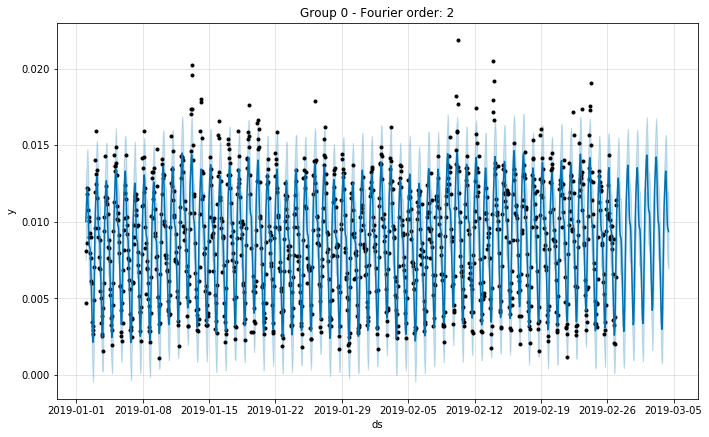

In sample evaluation:
RMSE	: 0.01692
MAE	: 0.01251
Out of sample evaluation:
RMSE	: 0.08266
MAE	: 0.07219


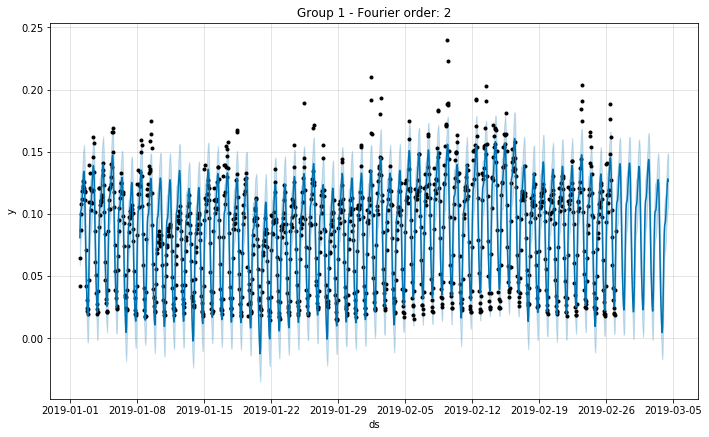

In sample evaluation:
RMSE	: 0.00544
MAE	: 0.00339
Out of sample evaluation:
RMSE	: 0.00695
MAE	: 0.00604


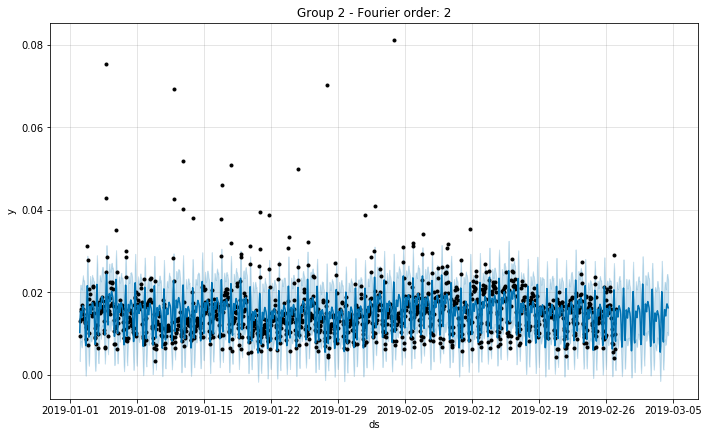

In sample evaluation:
RMSE	: 0.02612
MAE	: 0.01304
Out of sample evaluation:
RMSE	: 0.02118
MAE	: 0.01923


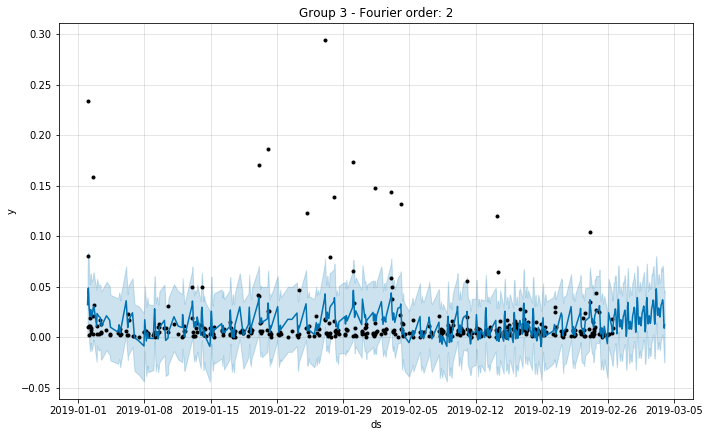

In sample evaluation:
RMSE	: 0.02505
MAE	: 0.01637
Out of sample evaluation:
RMSE	: 0.10172
MAE	: 0.08980


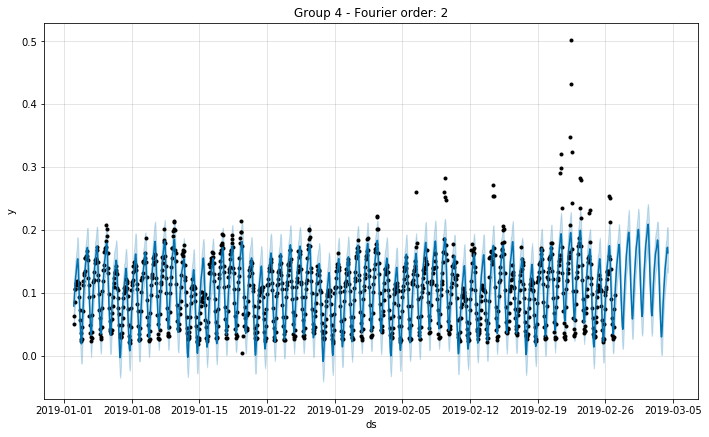

In sample evaluation:
RMSE	: 0.02270
MAE	: 0.01277
Out of sample evaluation:
RMSE	: 0.05093
MAE	: 0.04386


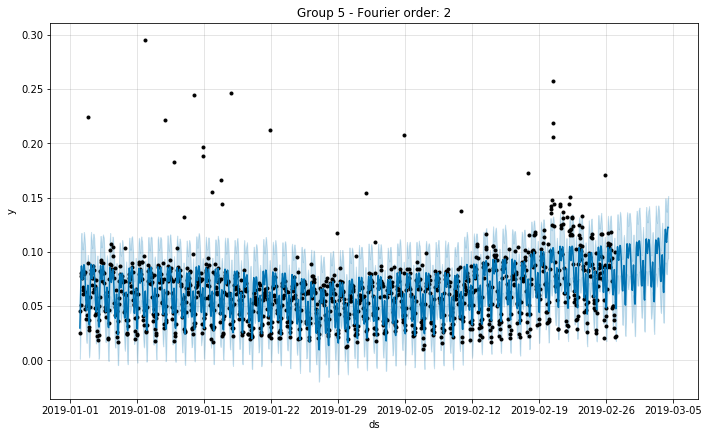

In sample evaluation:
RMSE	: 0.01339
MAE	: 0.00990
Out of sample evaluation:
RMSE	: 0.05405
MAE	: 0.04746


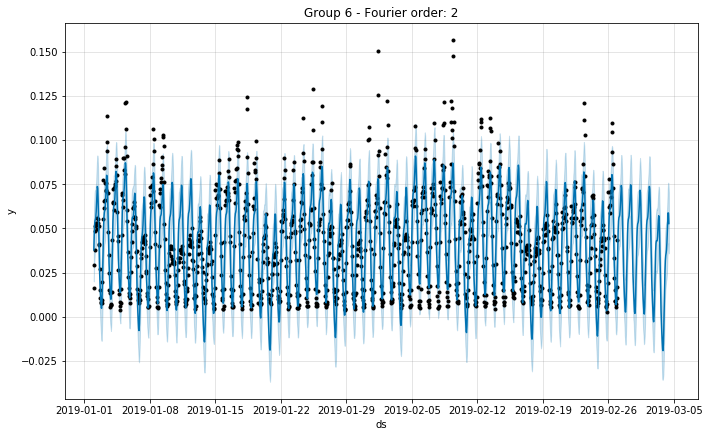

In sample evaluation:
RMSE	: 0.01028
MAE	: 0.00704
Out of sample evaluation:
RMSE	: 0.03928
MAE	: 0.03400


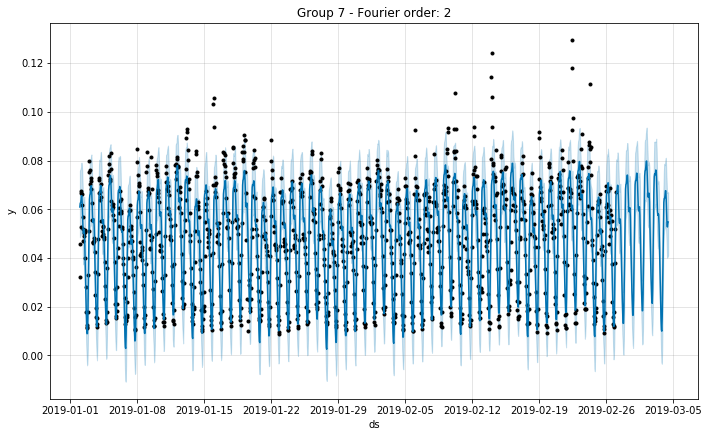

In [23]:
day_past = {
    1: 0,
    2: 31,
    3: 28+31,
    4: 31+28+31
}

# observe best fourier_order parameter value
from fbprophet import Prophet

order = 2
forecast_agg_all_grp = {}

for grp in sorted(train['group'].unique()):
    m = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True);
    m.add_seasonality(period=30.4375, fourier_order=order+1, name='monthly');
    m.fit(train_agg_day_grp[grp]);
    future = m.make_future_dataframe(periods=132, freq='H');
    forecast_agg_all_grp[grp] = m.predict(future);
    m.plot(forecast_agg_all_grp[grp]);
    plt.title("Group {} - Fourier order: {}".format(grp, order));
    forecast_agg_all_grp[grp]['group'] = grp

    print("In sample evaluation:")
    evaluate_prediction(forecast_agg_all_grp[grp].loc[:train_agg_day_grp[grp].shape[0]-1,'yhat'], train_agg_day_grp[grp]['y'])
    
    print("Out of sample evaluation:")
    shape = test_agg_day_grp[grp].shape[0]
    evaluate_prediction(forecast_agg_all_grp[grp].iloc[-shape:]['yhat'], test_agg_day_grp[grp]['y'])

    forecast_agg_all_grp[grp]['day'] = forecast_agg_all_grp[grp].apply(lambda x: x['ds'].date().day - 1 + day_past[x['ds'].date().month], axis=1)
    forecast_agg_all_grp[grp]['hour_of_day'] = forecast_agg_all_grp[grp]['ds'].dt.hour

    plt.show();

In [24]:
forecast_agg_all_grp_combined = pd.DataFrame(columns=['day','hour_of_day','yhat','group'])

for grp in train['group'].unique():
    forecast_agg_all_grp_combined = pd.concat(
        [
            forecast_agg_all_grp_combined,
            forecast_agg_all_grp[grp][['day','hour_of_day','yhat','group']].copy()
        ]
    )
    
forecast_agg_all_grp_combined['day'] = np.int64(forecast_agg_all_grp_combined['day'])
forecast_agg_all_grp_combined['group'] = np.int64(forecast_agg_all_grp_combined['group'])

In [25]:
train = train.merge(
    forecast_agg_all_grp_combined[['day','hour_of_day','yhat','group']],
    how='left',
    on=['day','hour_of_day','group']
).rename(columns={'yhat':'yhat_prophet_group'})

test = test.merge(
    forecast_agg_all_grp_combined[['day','hour_of_day','yhat','group']],
    how='left',
    on=['group','day','hour_of_day']
).rename(columns={'yhat':'yhat_prophet_group'})

In [26]:
evaluate_prediction(train['yhat_prophet_group'], train['demand'])

RMSE	: 0.14775
MAE	: 0.07101


In [29]:
evaluate_prediction(test['yhat_prophet_group'], test['demand'])

RMSE	: 0.15699
MAE	: 0.07742


Now, let's see whether we get better performance by forecasting the normalized demand.

In [30]:
train_agg_day_grp = {}

for grp in train['group'].unique():
    train_agg_day_grp[grp] = train.loc[(train['group'] == grp)].groupby(['day','hour_of_day']).agg({'demand_norm':np.median}).reset_index()
    train_agg_day_grp[grp]['ds'] = train_agg_day_grp[grp]['day'].apply(lambda x: pd.to_datetime('2019-01-01') + np.timedelta64(x,'D'))
    train_agg_day_grp[grp]['ds'] = train_agg_day_grp[grp].apply(lambda x: (x['ds'] + np.timedelta64(x['hour_of_day'],'h')), axis=1)
    train_agg_day_grp[grp] = train_agg_day_grp[grp][['ds','demand_norm']].copy()
    train_agg_day_grp[grp].rename(columns={'demand_norm':'y'}, inplace=True)

In sample evaluation:
RMSE	: 0.16692
MAE	: 0.12171
Out of sample evaluation:
RMSE	: 0.78691
MAE	: 0.72410


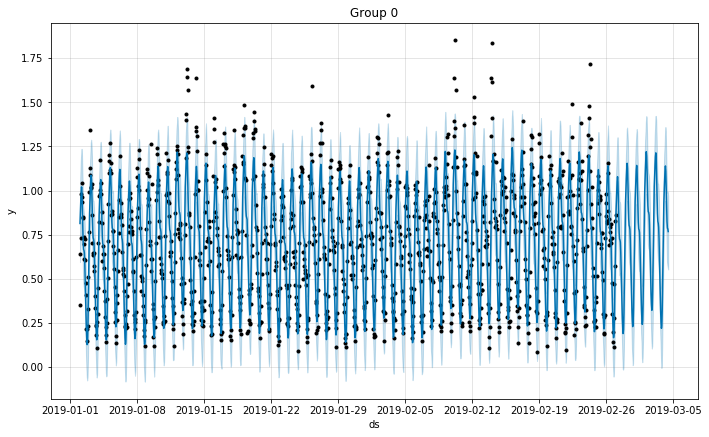

In sample evaluation:
RMSE	: 0.17955
MAE	: 0.13405
Out of sample evaluation:
RMSE	: 0.91073
MAE	: 0.77461


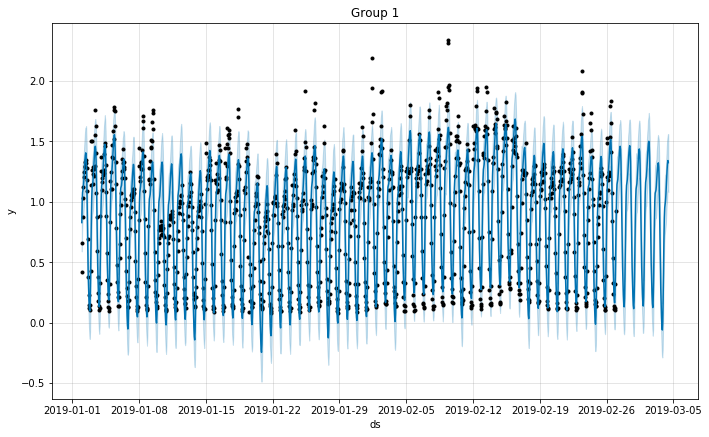

In sample evaluation:
RMSE	: 0.17775
MAE	: 0.13310
Out of sample evaluation:
RMSE	: 0.67526
MAE	: 0.64889


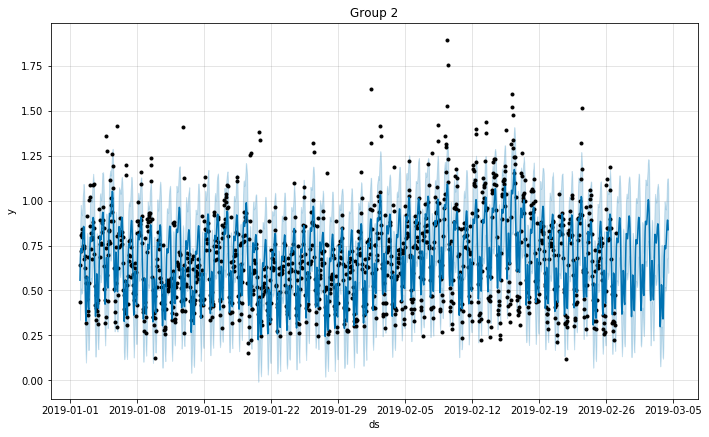

In sample evaluation:
RMSE	: 0.68021
MAE	: 0.46611
Out of sample evaluation:
RMSE	: 1.23554
MAE	: 1.16105


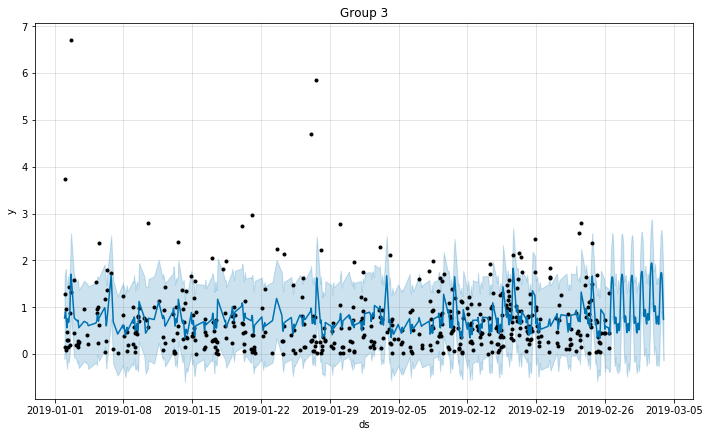

In sample evaluation:
RMSE	: 0.21709
MAE	: 0.14815
Out of sample evaluation:
RMSE	: 1.11698
MAE	: 1.00021


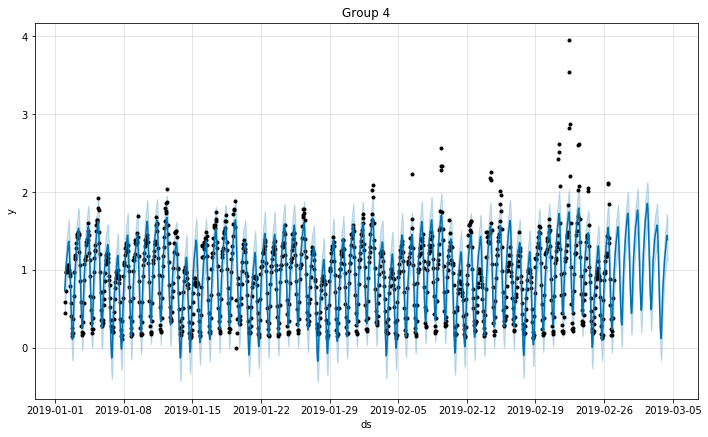

In sample evaluation:
RMSE	: 0.24206
MAE	: 0.14096
Out of sample evaluation:
RMSE	: 1.08775
MAE	: 1.03076


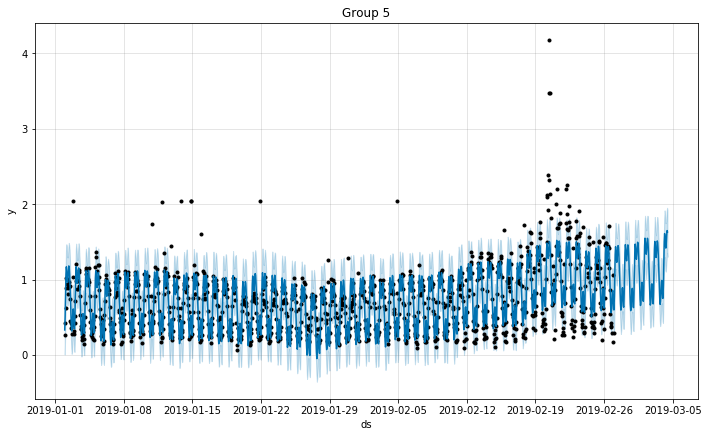

In sample evaluation:
RMSE	: 0.26244
MAE	: 0.19450
Out of sample evaluation:
RMSE	: 0.74598
MAE	: 0.61347


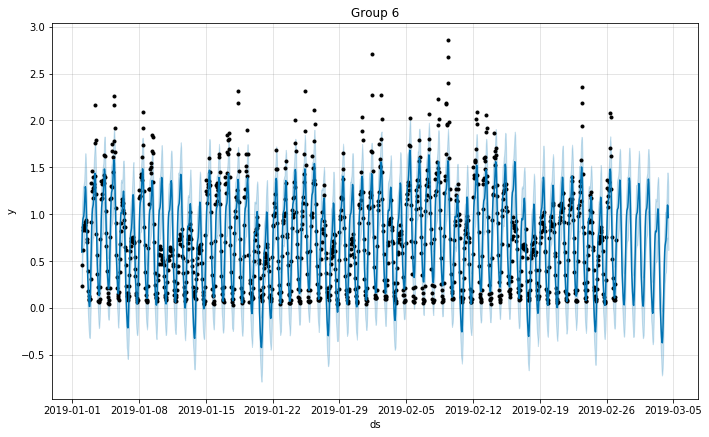

In sample evaluation:
RMSE	: 0.21108
MAE	: 0.14598
Out of sample evaluation:
RMSE	: 1.06165
MAE	: 0.96420


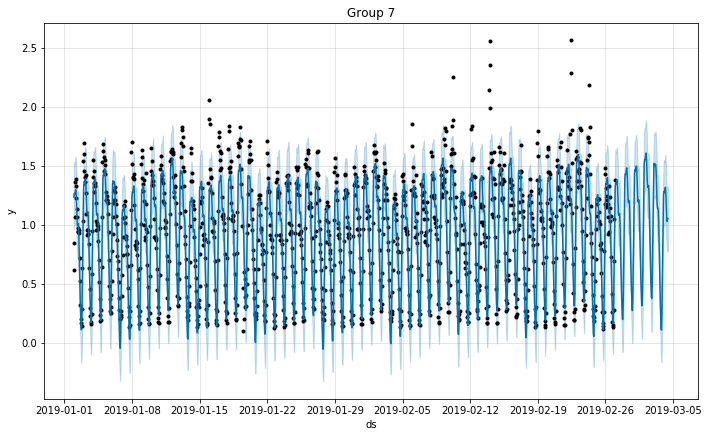

In [31]:
from fbprophet import Prophet

order = 2
forecast_agg_all_grp = {}

for grp in sorted(train['group'].unique()):
    m = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True);
    m.add_seasonality(period=30.4375, fourier_order=order+1, name='monthly');
    m.fit(train_agg_day_grp[grp]);
    future = m.make_future_dataframe(periods=132, freq='H');
    forecast_agg_all_grp[grp] = m.predict(future);
    m.plot(forecast_agg_all_grp[grp]);
    plt.title("Group {}".format(grp));
    forecast_agg_all_grp[grp]['group'] = grp

    print("In sample evaluation:")
    evaluate_prediction(forecast_agg_all_grp[grp].loc[:train_agg_day_grp[grp].shape[0]-1,'yhat'], train_agg_day_grp[grp]['y'])
    
    print("Out of sample evaluation:")
    shape = test_agg_day_grp[grp].shape[0]
    evaluate_prediction(forecast_agg_all_grp[grp].iloc[-shape:]['yhat'], test_agg_day_grp[grp]['y'])

    forecast_agg_all_grp[grp]['day'] = forecast_agg_all_grp[grp].apply(lambda x: x['ds'].date().day - 1 + day_past[x['ds'].date().month], axis=1)
    forecast_agg_all_grp[grp]['hour_of_day'] = forecast_agg_all_grp[grp]['ds'].dt.hour

    plt.show();

In [32]:
forecast_agg_all_grp_combined = pd.DataFrame(columns=['day','hour_of_day','yhat','group'])

for grp in train['group'].unique():
    forecast_agg_all_grp_combined = pd.concat(
        [
            forecast_agg_all_grp_combined,
            forecast_agg_all_grp[grp][['day','hour_of_day','yhat','group']].copy()
        ]
    )
    
forecast_agg_all_grp_combined['day'] = np.int64(forecast_agg_all_grp_combined['day'])
forecast_agg_all_grp_combined['group'] = np.int64(forecast_agg_all_grp_combined['group'])

In [33]:
train = train.merge(
    forecast_agg_all_grp_combined[['day','hour_of_day','yhat','group']],
    how='left',
    on=['day','group','hour_of_day']
).rename(columns={'yhat':'yhat_prophet_group_norm'})

test = test.merge(
    forecast_agg_all_grp_combined[['day','hour_of_day','yhat','group']],
    how='left',
    on=['group','day','hour_of_day']
).rename(columns={'yhat':'yhat_prophet_group_norm'})

In [34]:
train['yhat_prophet_group_norm_converted'] = train['yhat_prophet_group_norm'] * train['demand_mean']
test['yhat_prophet_group_norm_converted'] = test['yhat_prophet_group_norm'] * test['demand_mean']

In [35]:
evaluate_prediction(train['yhat_prophet_group_norm_converted'], train['demand'])

RMSE	: 0.06758
MAE	: 0.03591


In [36]:
evaluate_prediction(test['yhat_prophet_group_norm_converted'], test['demand'])

RMSE	: 0.06923
MAE	: 0.03837


## Visualize

As seen on sample locations below, this model still tends to underestimate the real demand. However, it still follows fluctuations on some locations - and its RMSE is 0.06923, which is better than the baseline approach.

In [37]:
obs = pd.concat(
    [
        train[['geohash6','day','timestamp','dt','demand','yhat_prophet_group_norm_converted']],
        test[['geohash6','day','timestamp','dt','demand','yhat_prophet_group_norm_converted']]
    ]
)

In [38]:
obs_melt = pd.melt(
    obs,
    id_vars=['geohash6','day','timestamp','dt'],
    value_vars=['demand','yhat_prophet_group_norm_converted']
)

/home/elvyna/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



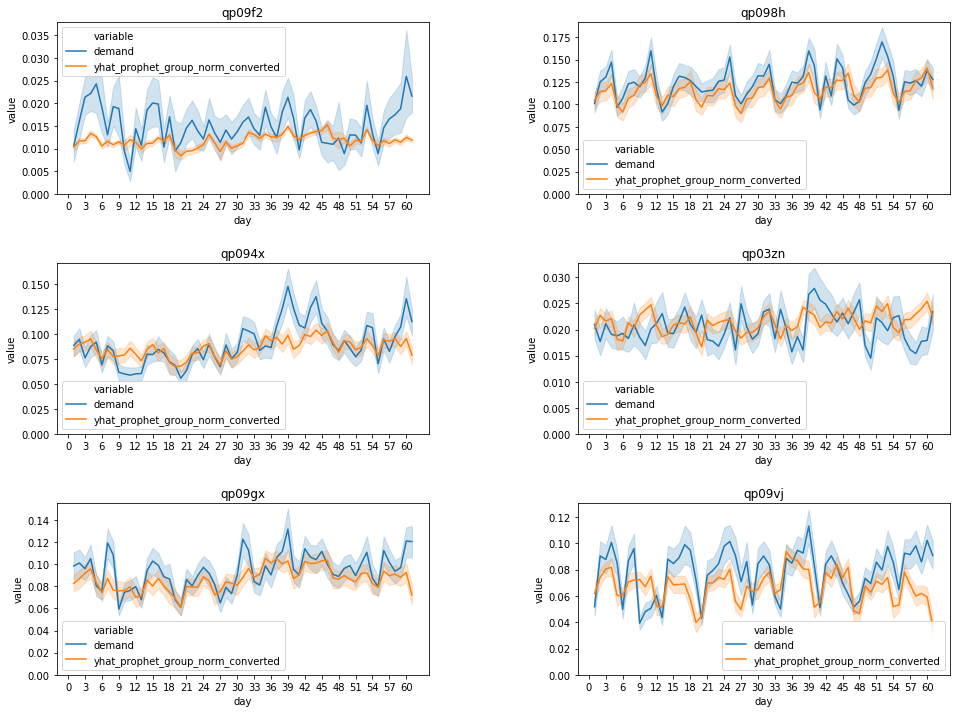

In [39]:
f, ax = plt.subplots(figsize=(16,12), ncols=2, nrows=3)
plt.subplots_adjust(wspace=.4, hspace=.4)
i = 0
j = 0

for geo in np.random.choice(np.arange(obs_melt['geohash6'].nunique()), 6):
    sns.lineplot(
        data=obs_melt.loc[(obs_melt['geohash6'] == obs_melt['geohash6'].unique()[geo])],
        x='day',
        y='value',
        hue='variable',
        ax=ax[i][j]
    )
    
    ax[i][j].set_title(obs_melt['geohash6'].unique()[geo])
    ax[i][j].set_ylim(0,)
    ax[i][j].set_xticks(np.arange(0,63,3))
    
    if j == 1:
        i += 1
        j = 0
    else:
        j += 1
    
    
plt.show();